In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Data extraction

In [ ]:
file_path_full_training_set = 'KDDTrain.txt'
file_path_test = 'KDDTest.txt'

df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)

In [ ]:
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df.columns = columns
test_df.columns = columns

# sanity check
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


# Data Preprocessing

In [ ]:
# map normal to 0, all attacks to 1
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)

df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1


In [ ]:
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

attack_labels = ['Normal','DoS','Probe','Privilege','Access']

def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks mapt to 2
        attack_type = 2
    elif attack in privilege_attacks:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in access_attacks:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0

    return attack_type

attack_map = df.attack.apply(map_attack)
df['attack_map'] = attack_map

test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1,1


# Feature Engineering

In [ ]:
# use a crosstab to get attack vs protocol
attack_vs_protocol = pd.crosstab(df.attack_map, df.protocol_type)
attack_vs_protocol

protocol_type,icmp,tcp,udp
attack_map,,,
0,1309,53608,12434
1,2847,42188,892
2,4135,5857,1664
3,0,40,3
4,0,995,0


In [ ]:
def bake_pies(data_list,labels):
    list_length = len(data_list)

    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}

    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)

    for count, data_set in enumerate(data_list):

        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)

        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        axs[count].set_title(labels[count])

    return axs



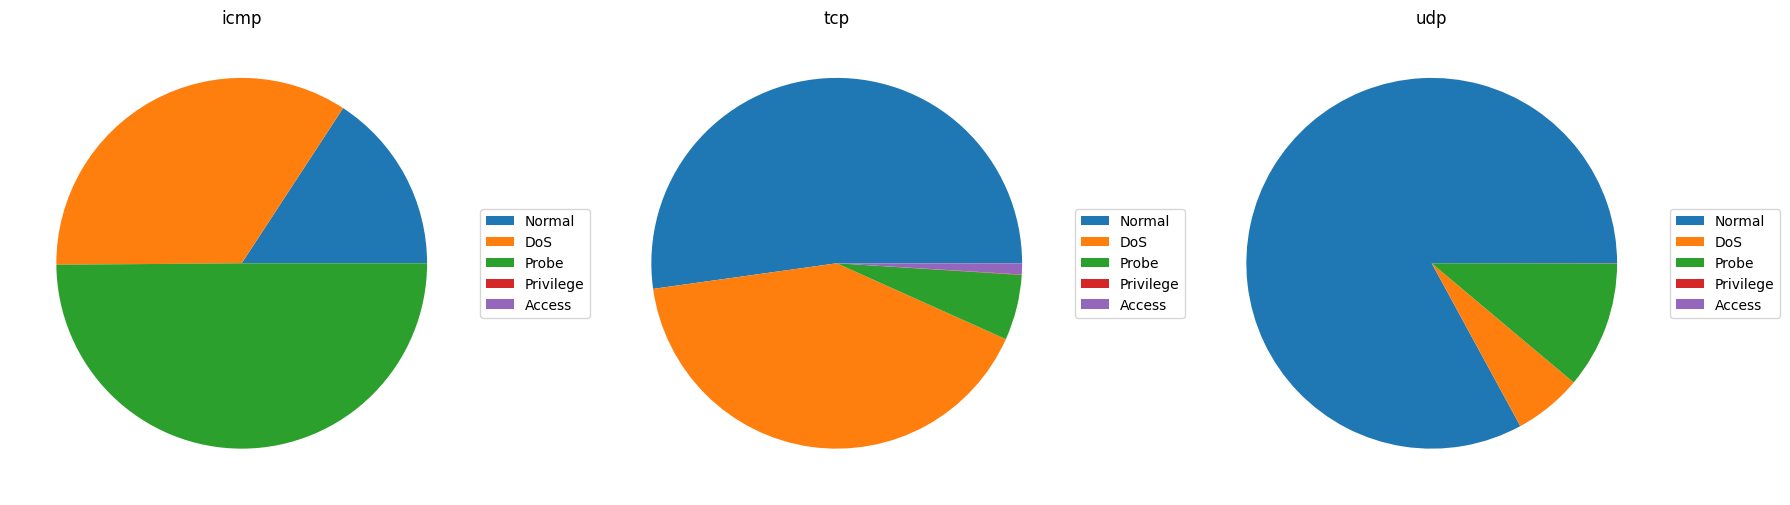

In [ ]:
import matplotlib.pyplot as plt
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp

axs = bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])

labels = ['Normal','DoS','Probe','Privilege','Access']
for i in range(3):
  axs[i].legend(axs[i].patches, labels, loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

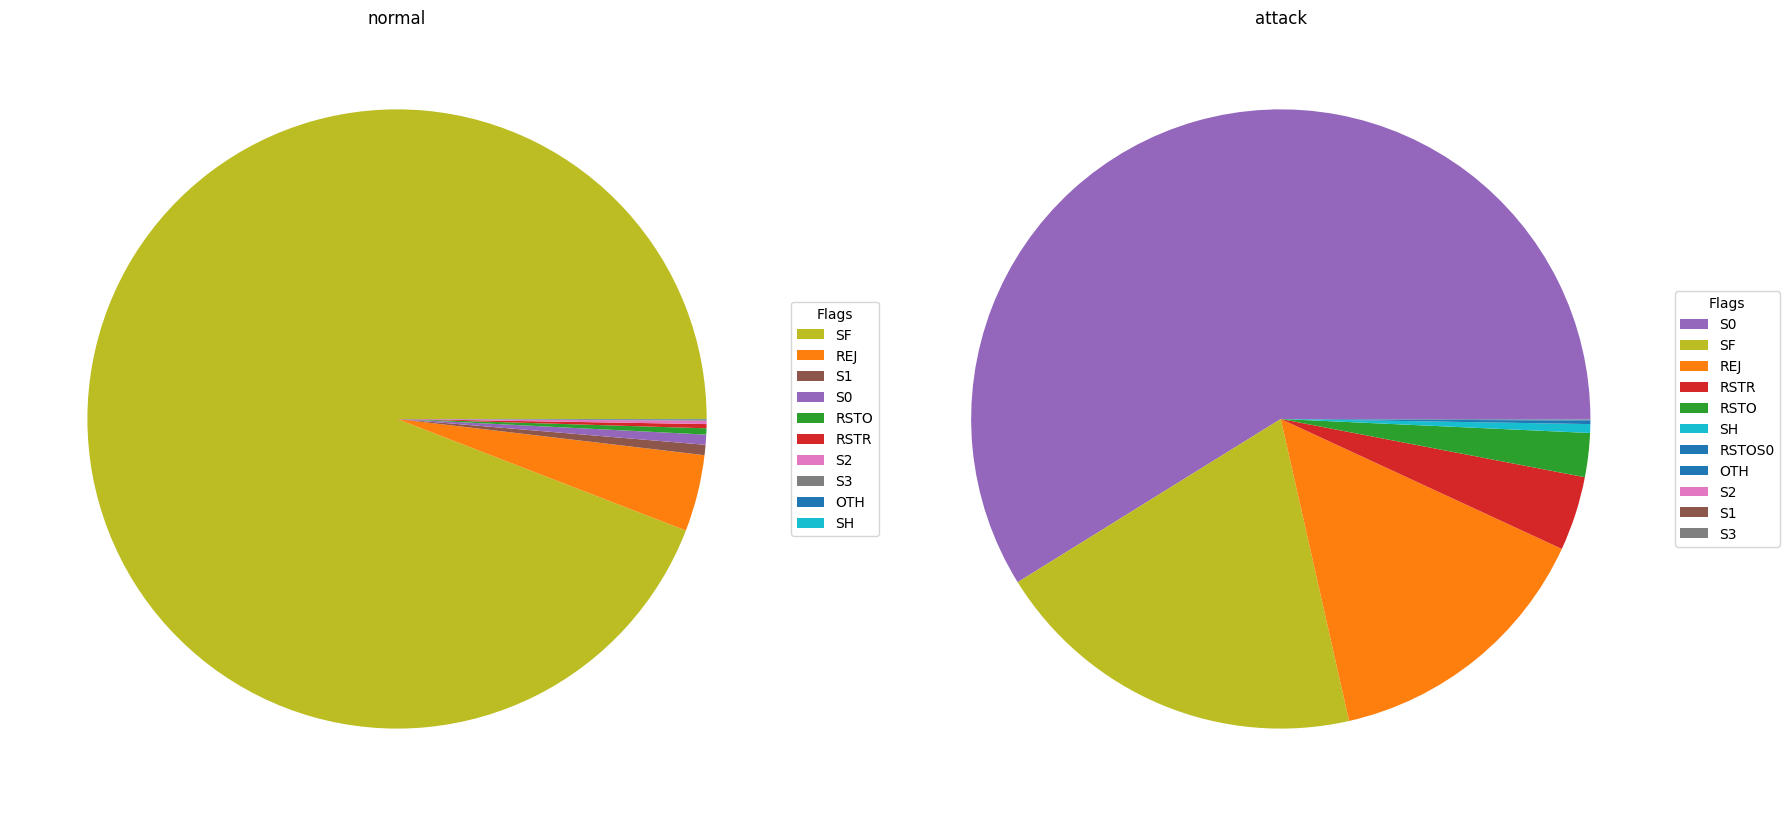

In [ ]:
normal_flags = df.loc[df.attack_flag == 0].flag.value_counts()
attack_flags = df.loc[df.attack_flag == 1].flag.value_counts()

flag_axs = bake_pies([normal_flags, attack_flags], ['normal','attack'])
plt.show()

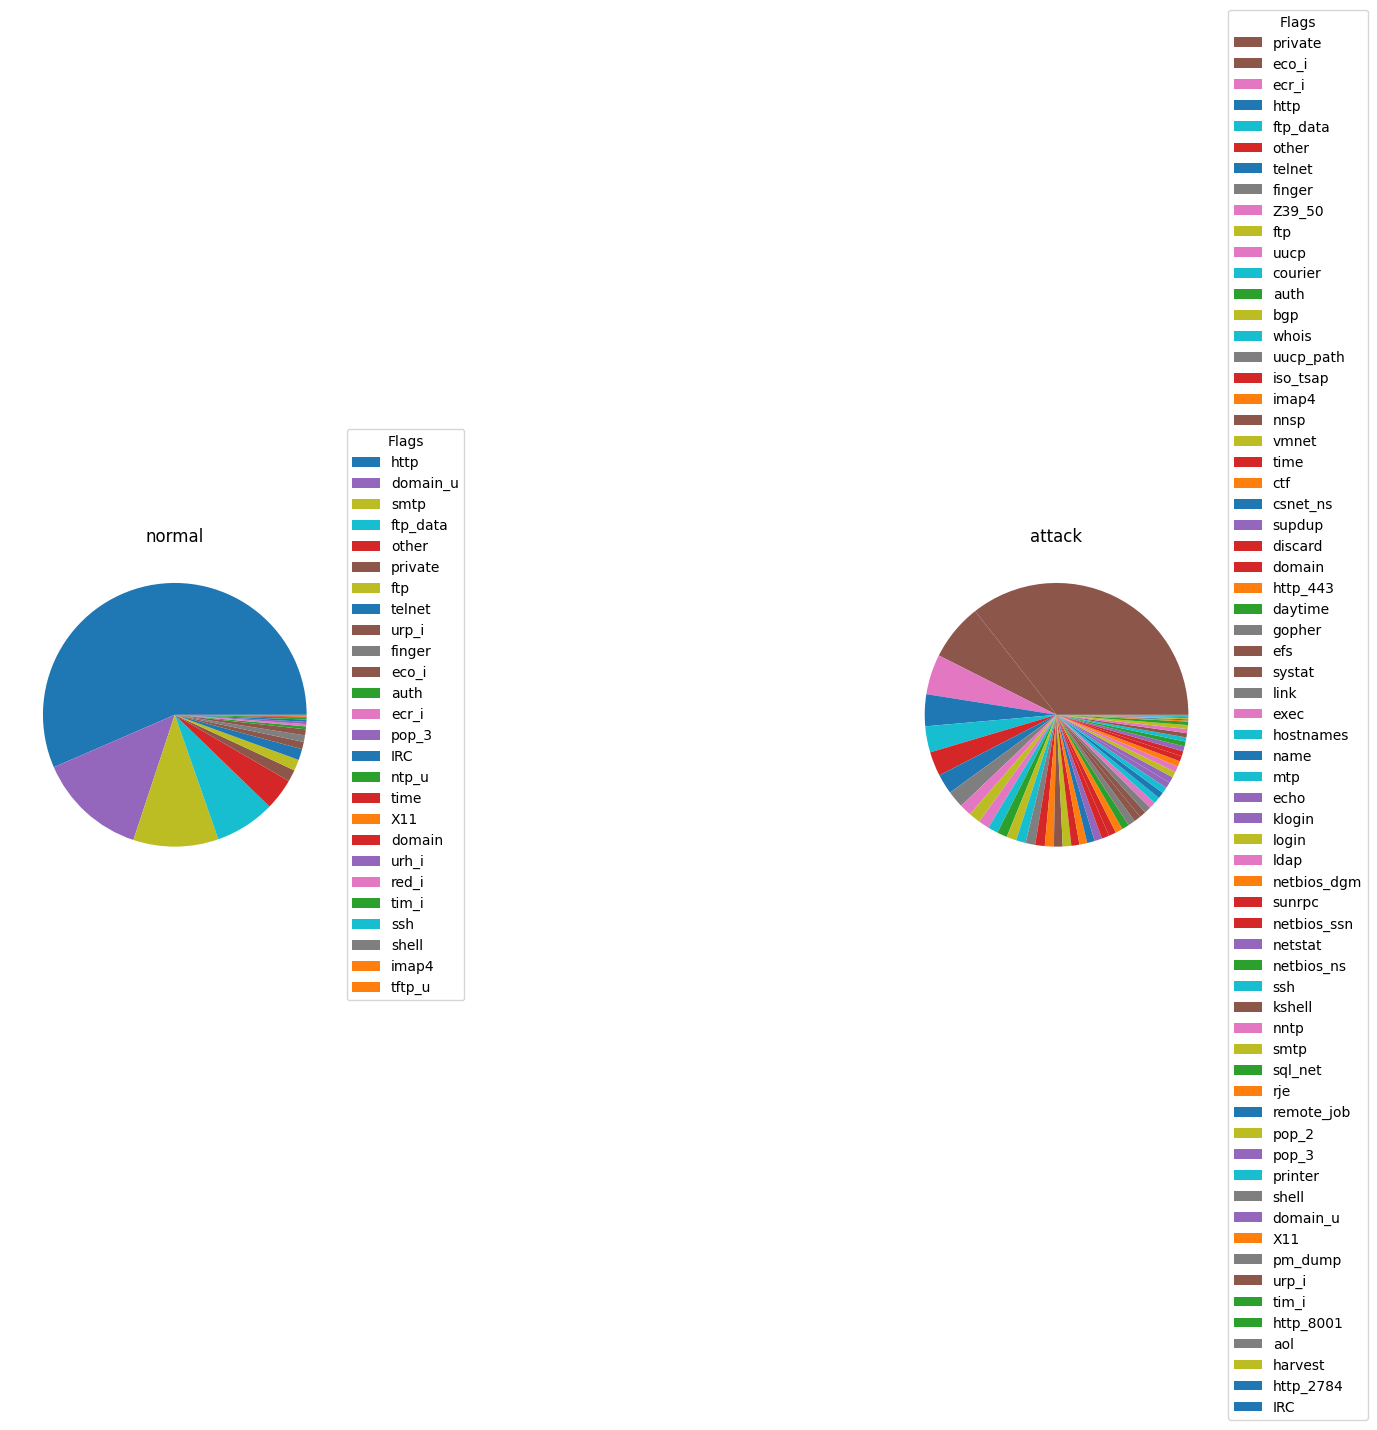

In [ ]:
normal_services = df.loc[df.attack_flag == 0].service.value_counts()
attack_services = df.loc[df.attack_flag == 1].service.value_counts()

service_axs = bake_pies([normal_services, attack_services], ['normal','attack'])
plt.show()


In [ ]:
features_to_encode = ['protocol_type', 'service', 'flag']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])

test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))

diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

column_order = encoded.columns.to_list()

test_encoded_temp = test_encoded_base.join(diff_df)

test_final = test_encoded_temp[column_order].fillna(0)

numeric_features = ['duration', 'src_bytes', 'dst_bytes']

to_fit = encoded.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])

In [ ]:
binary_y = df['attack_flag']
multi_y = df['attack_map']

test_binary_y = test_df['attack_flag']
test_multi_y = test_df['attack_map']

binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.6)
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(to_fit, multi_y, test_size = 0.6)

# Model fitting

In [ ]:
def GridSearch(Model_Abb, Parameters, X_train, Y_train):
    Grid = GridSearchCV(estimator=Model_Abb, param_grid= Parameters, cv = 3, n_jobs=-1)
    Grid_Result = Grid.fit(X_train, Y_train)
    Model_Name = Grid_Result.best_estimator_

    return (Model_Name)

In [ ]:
max_depth= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Parameters={ 'max_depth': max_depth}

In [ ]:
# model for the binary classification
binary_model = RandomForestClassifier()
GridSearch(binary_model, Parameters, binary_train_X, binary_train_y)
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)

base_rf_score = accuracy_score(binary_predictions,binary_val_y)
base_rf_score

0.9932922311600338

# Model Evaluation

In [ ]:
def add_predictions(data_set,predictions,y):
    prediction_series = pd.Series(predictions, index=y.index)

    predicted_vs_actual = data_set.assign(predicted=prediction_series)
    original_data = predicted_vs_actual.assign(actual=y).dropna()
    conf_matrix = confusion_matrix(original_data['actual'],
                                   original_data['predicted'])

    base_errors = original_data[original_data['actual'] != original_data['predicted']]

    non_zeros = base_errors.loc[:,(base_errors != 0).any(axis=0)]

    false_positives = non_zeros.loc[non_zeros.actual==0]
    false_negatives = non_zeros.loc[non_zeros.actual==1]

    prediction_data = {'data': original_data,
                       'confusion_matrix': conf_matrix,
                       'errors': base_errors,
                       'non_zeros': non_zeros,
                       'false_positives': false_positives,
                       'false_negatives': false_negatives}

    return prediction_data


<Axes: >

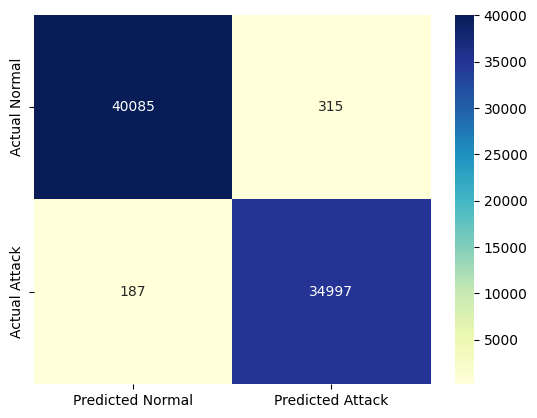

In [ ]:
binary_prediction_data = add_predictions(df,
                                         binary_predictions,
                                         binary_val_y)

sns.heatmap(data=binary_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

In [ ]:
def Evaluate(Model_Name, Model_Abb, X_test, Y_test):

    Pred_Value= Model_Abb.predict(X_test)
    Accuracy = metrics.accuracy_score(Y_test,Pred_Value)
    Sensitivity = metrics.recall_score(Y_test,Pred_Value)
    Precision = metrics.precision_score(Y_test,Pred_Value)
    F1_score = metrics.f1_score(Y_test,Pred_Value)
    Recall = metrics.recall_score(Y_test,Pred_Value)

    print('--------------------------------------------------\n')
    print('The {} Model Accuracy   = {}\n'.format(Model_Name, np.round(Accuracy,3)))
    print('The {} Model Sensitvity = {}\n'.format(Model_Name, np.round(Sensitivity,3)))
    print('The {} Model Precision  = {}\n'.format(Model_Name, np.round(Precision,3)))
    print('The {} Model F1 Score   = {}\n'.format(Model_Name, np.round(F1_score,3)))
    print('The {} Model Recall     = {}\n'.format(Model_Name, np.round(Recall,3)))
    print('--------------------------------------------------\n')

In [ ]:
Evaluate('Random Forest Binary Classifier', binary_model, binary_val_X, binary_val_y)

--------------------------------------------------

The Random Forest Binary Classifier Model Accuracy   = 0.993

The Random Forest Binary Classifier Model Sensitvity = 0.995

The Random Forest Binary Classifier Model Precision  = 0.991

The Random Forest Binary Classifier Model F1 Score   = 0.993

The Random Forest Binary Classifier Model Recall     = 0.995

--------------------------------------------------



In [ ]:
binary_model.predict(binary_val_X)

array([1, 0, 1, ..., 1, 0, 1])

In [ ]:
binary_prediction_data['errors'].describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,attack_flag,attack_map,predicted,actual
count,502.000000,5.020000e+02,502.000000,502.000000,502.0,502.000000,502.000000,502.000000,502.000000,502.000000,...,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000
mean,62.049801,3.086161e+04,525.426295,0.007968,0.0,0.007968,0.175299,0.009960,0.081673,0.187251,...,0.052211,0.092908,0.031275,0.343048,0.384263,15.523904,0.372510,0.605578,0.627490,0.372510
std,689.192950,3.961694e+05,3427.023252,0.088997,0.0,0.109144,1.180830,0.223161,0.274140,2.109951,...,0.169614,0.233163,0.137829,0.460761,0.473433,5.322571,0.483955,1.004883,0.483955,0.483955
min,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010000,0.010000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.020000,0.040000,0.010000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000
max,12743.000000,5.135678e+06,51633.000000,1.000000,0.0,2.000000,18.000000,5.000000,1.000000,38.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,1.000000,4.000000,1.000000,1.000000


In [ ]:
binary_prediction_data['non_zeros'].describe()

,duration,src_bytes,dst_bytes,land,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,...,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,attack_flag,attack_map,predicted,actual
count,502.000000,5.020000e+02,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,...,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000
mean,62.049801,3.086161e+04,525.426295,0.007968,0.007968,0.175299,0.009960,0.081673,0.187251,0.019920,...,0.052211,0.092908,0.031275,0.343048,0.384263,15.523904,0.372510,0.605578,0.627490,0.372510
std,689.192950,3.961694e+05,3427.023252,0.088997,0.109144,1.180830,0.223161,0.274140,2.109951,0.139866,...,0.169614,0.233163,0.137829,0.460761,0.473433,5.322571,0.483955,1.004883,0.483955,0.483955
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010000,0.010000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.020000,0.040000,0.010000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000
max,12743.000000,5.135678e+06,51633.000000,1.000000,2.000000,18.000000,5.000000,1.000000,38.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,1.000000,4.000000,1.000000,1.000000


In [ ]:
binary_prediction_data['false_positives'].std()

<ipython-input-63-7110a465a362>:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  binary_prediction_data['false_positives'].std()


duration                         11.104744
src_bytes                      3103.126919
dst_bytes                      1078.863399
land                              0.112148
urgent                            0.000000
hot                               0.269127
num_failed_logins                 0.000000
logged_in                         0.166864
num_compromised                   0.056344
root_shell                        0.056344
su_attempted                      0.000000
num_root                          0.507093
num_file_creations                0.000000
num_shells                        0.000000
num_access_files                  0.000000
is_guest_login                    0.000000
count                             4.426572
srv_count                         4.615566
serror_rate                       0.321796
srv_serror_rate                   0.308692
rerror_rate                       0.430243
srv_rerror_rate                   0.426424
same_srv_rate                     0.119822
diff_srv_ra

In [ ]:
binary_prediction_data['false_negatives'].std()

<ipython-input-64-7ed8fdcd94da>:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  binary_prediction_data['false_negatives'].std()


duration                         1123.478311
src_bytes                      646888.207404
dst_bytes                        5398.915230
land                                0.000000
urgent                              0.178320
hot                                 1.880325
num_failed_logins                   0.365636
logged_in                           0.377627
num_compromised                     3.439765
root_shell                          0.214612
su_attempted                        0.073127
num_root                            5.098050
num_file_creations                  2.114390
num_shells                          0.240273
num_access_files                    0.238351
is_guest_login                      0.161750
count                             119.881555
srv_count                           6.311113
serror_rate                         0.138464
srv_serror_rate                     0.174794
rerror_rate                         0.449512
srv_rerror_rate                     0.460783
same_srv_r

<Axes: >

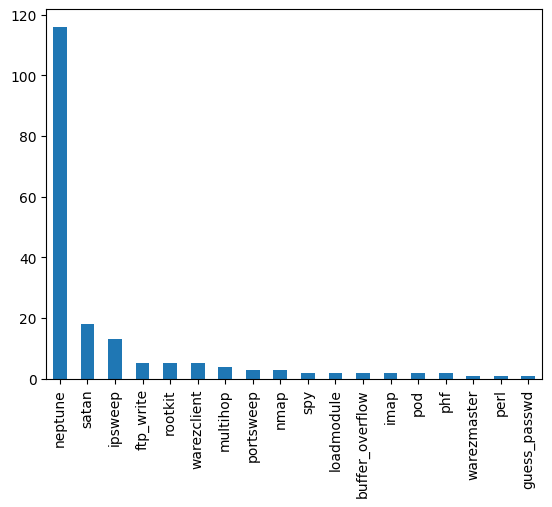

In [ ]:
binary_prediction_data['false_negatives'].attack.value_counts().plot.bar()

In [ ]:
outcomes = ['attack_flag','attack_map', 'actual']

new_features = (binary_prediction_data['false_positives']==0).all(axis=0)
feature_cols = binary_prediction_data['false_positives'].loc[:,new_features]
feature_cols = feature_cols.drop(outcomes,axis=1)

new_feature_columns = list(feature_cols.columns)
new_feature_columns

['urgent',
 'num_failed_logins',
 'su_attempted',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'is_guest_login']

In [ ]:
to_fit_new_features = to_fit.join(df[new_feature_columns])

new_feature_train_X, new_feature_val_X, new_feature_train_y, new_feature_val_y = train_test_split(to_fit_new_features, binary_y)

In [ ]:
new_feature_model = RandomForestClassifier()
new_feature_model.fit(new_feature_train_X, new_feature_train_y)
new_feature_predictions = new_feature_model.predict(new_feature_val_X)

new_feature_score = accuracy_score(new_feature_predictions,new_feature_val_y)

new_feature_score

0.9934588638745118

<Axes: >

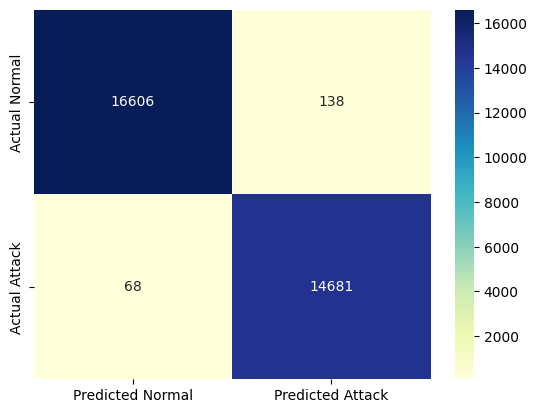

In [ ]:
new_prediction_data = add_predictions(df,
                                      new_feature_predictions,
                                      new_feature_val_y)

sns.heatmap(data=new_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

<Axes: >

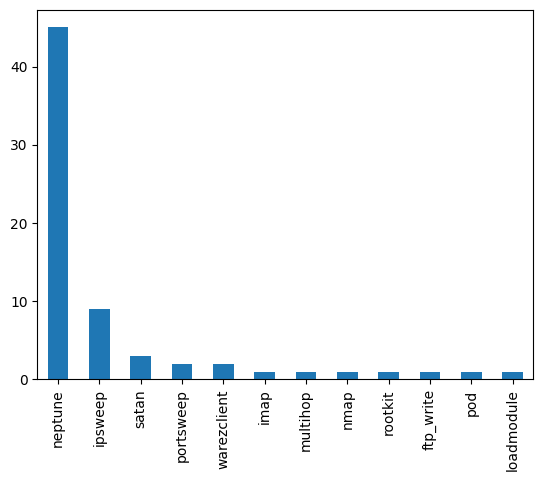

In [ ]:
new_prediction_data['false_negatives'].attack.value_counts().plot.bar()

In [ ]:
multi_feature_train_X, multi_feature_val_X, multi_feature_train_y, multi_feature_val_y = train_test_split(to_fit_new_features, multi_y)

In [ ]:
multi_model = RandomForestClassifier()
multi_model.fit(multi_feature_train_X, multi_feature_train_y)
multi_predictions = multi_model.predict(multi_feature_val_X)

accuracy_score(multi_predictions,multi_feature_val_y)

0.9775188137046328

<Axes: >

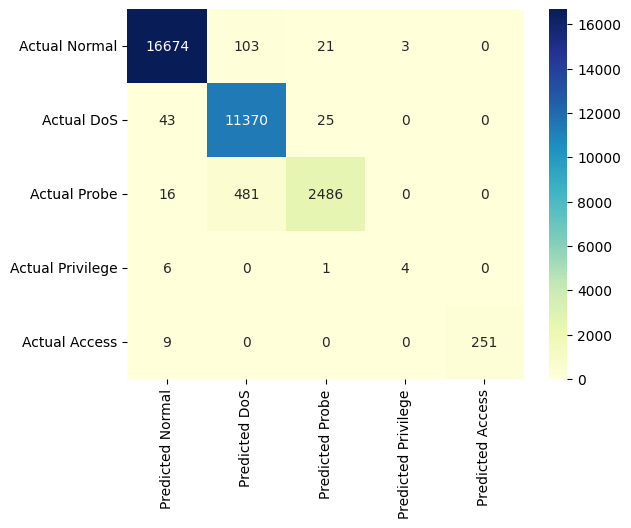

In [ ]:
multi_prediction_data = add_predictions(df, multi_predictions, multi_feature_val_y)

sns.heatmap(data=multi_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted ' + x for x in attack_labels],
            yticklabels = ['Actual ' + x for x in attack_labels],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

In [ ]:
with open('binary_rf_model.pkl', 'wb') as f:
  pickle.dump(binary_model, f)

In [ ]:
with open('multi_rf_model.pkl', 'wb') as f:
  pickle.dump(multi_model, f)